In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path
from pyomo.environ import *
from pyomo.gdp import *

In [7]:
JOBS = {
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due': 5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}

JOBS = {
    'A':{"name":"p1","duration":60,"dependencies":None},
    'B':{"name":"p2","duration":120,"dependencies":None},
    'C': {"name":"p3","duration":120,"dependencies":None}
}

In [ ]:
def spt(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        spt = {job:JOBS[job]['duration'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(spt, key=spt.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(JOBS, spt(JOBS))
kpi(JOBS, spt(JOBS))

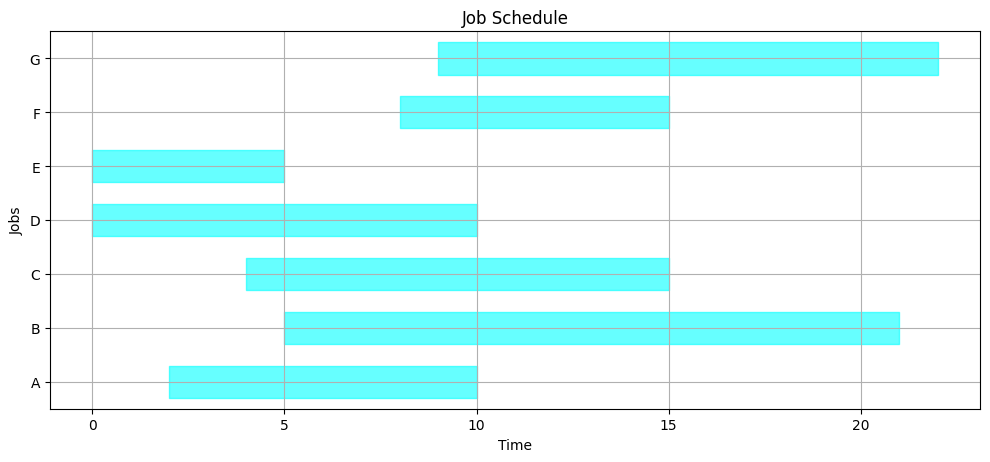

In [9]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()
    
    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

gantt(JOBS)

In [10]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE   

SCHEDULE = schedule(JOBS)
SCHEDULE

{'A': {'start': 2, 'finish': 7},
 'B': {'start': 7, 'finish': 13},
 'C': {'start': 13, 'finish': 21},
 'D': {'start': 21, 'finish': 25},
 'E': {'start': 25, 'finish': 27},
 'F': {'start': 27, 'finish': 30},
 'G': {'start': 30, 'finish': 32}}

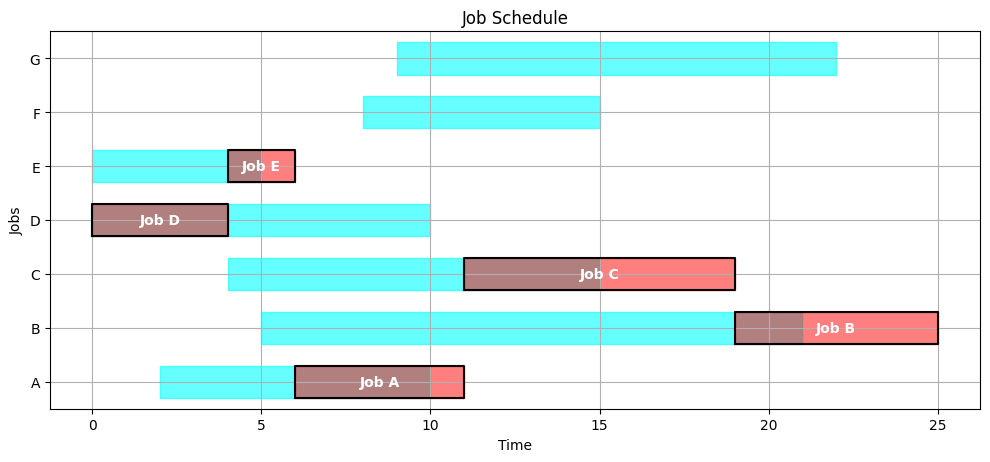

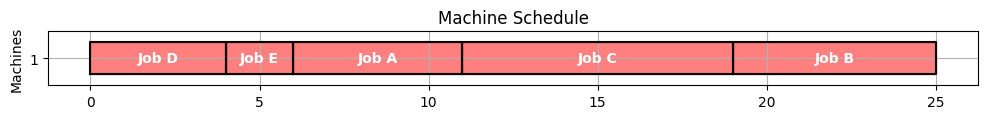

In [12]:
gantt(JOBS, schedule(JOBS, ['D', 'E', 'A', 'C', 'B']))

In [16]:
JOBS

{'A': {'release': 2, 'duration': 5, 'due': 10},
 'B': {'release': 5, 'duration': 6, 'due': 21},
 'C': {'release': 4, 'duration': 8, 'due': 15},
 'D': {'release': 0, 'duration': 4, 'due': 10},
 'E': {'release': 0, 'duration': 2, 'due': 5},
 'F': {'release': 8, 'duration': 3, 'due': 15},
 'G': {'release': 9, 'duration': 2, 'due': 22}}

In [15]:
SCHEDULE

{'A': {'start': 2, 'finish': 7, 'machine': 1},
 'B': {'start': 7, 'finish': 13, 'machine': 1},
 'C': {'start': 13, 'finish': 21, 'machine': 1},
 'D': {'start': 21, 'finish': 25, 'machine': 1},
 'E': {'start': 25, 'finish': 27, 'machine': 1},
 'F': {'start': 27, 'finish': 30, 'machine': 1},
 'G': {'start': 30, 'finish': 32, 'machine': 1}}

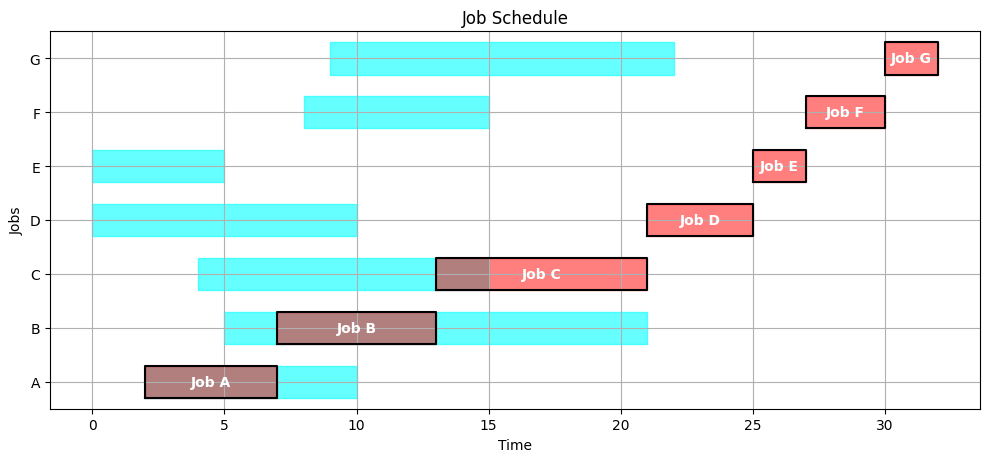

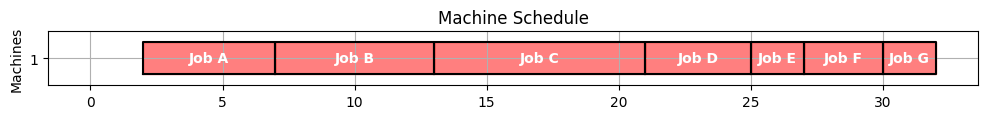

In [13]:
gantt(JOBS, SCHEDULE)


In [17]:
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

kpi(JOBS, SCHEDULE)

{'Makespan': 32,
 'Max Pastdue': 22,
 'Sum of Pastdue': 68,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

{'Makespan': 39,
 'Max Pastdue': 29,
 'Sum of Pastdue': 76,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

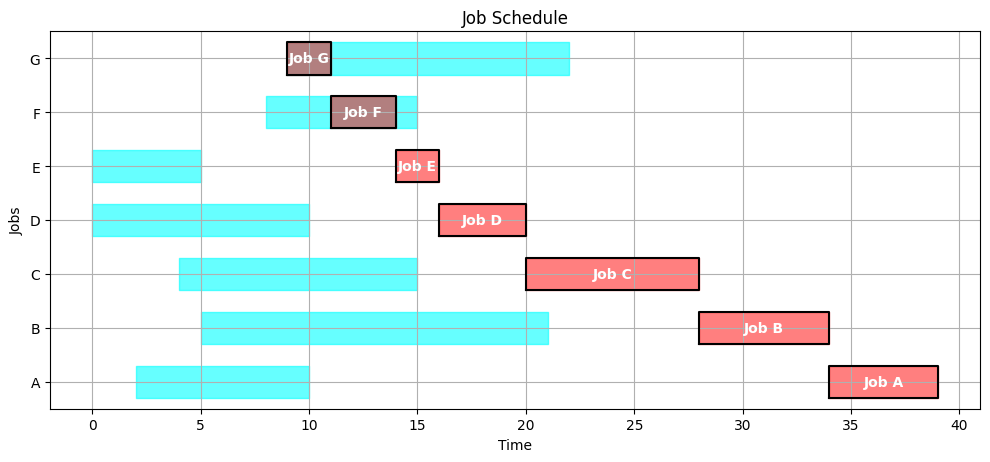

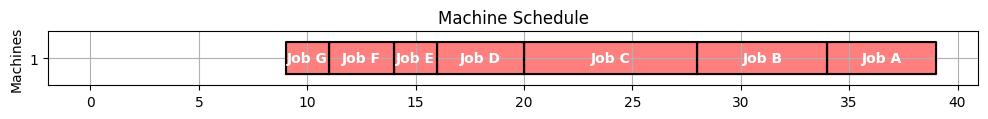

In [18]:
order = sorted(JOBS, reverse=True)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path
from pyomo.gdp import *
import pyomo.environ as pe
import numpy as np
import math

In [2]:
m = pe.ConcreteModel()
T =90
duration=30

In [3]:
m.Y = pe.RangeSet(1, T - duration)
m.S = pe.RangeSet(0, duration - 1)

In [4]:
processes= {'p1': {'start_window': 0, 'end_window': 118, 'duration': 12, 'dependencies': None}, 'p2': {'start_window': 0, 'end_window': 118, 'duration': 6, 'dependencies': None}, 'p3': {'start_window': 0, 'end_window': 118, 'duration': 9, 'dependencies': None}}

In [5]:
m.processes = pe.Set(initialize=processes.keys())
print([p for p in m.processes])

['p1', 'p2', 'p3']


In [6]:
m.process_pairs = pe.Set(initialize = m.processes * m.processes, dimen=2, filter=lambda m, j, k : j < k)
print([(j,k) for j,k in m.process_pairs])

[('p1', 'p2'), ('p1', 'p3'), ('p2', 'p3')]


In [7]:
m.y = pe.Var(m.process_pairs, domain=pe.Boolean)
print([(j,k) for j,k in m.y])

[('p1', 'p2'), ('p1', 'p3'), ('p2', 'p3')]


In [8]:
m.start = pe.Var(m.processes, initialize=0, domain=pe.NonNegativeReals)
print([pe.value(m.start[s]) for s in m.start])

[0, 0, 0]


In [12]:
# Process is not running except during the working duration
m.Y = pe.RangeSet(1, T - duration)
print([s for s in m.Y])
m.Yy = pe.Set(m.processes*m.Y)

# m.Y_combined = pe.Var(m.Yy, initialize=0, domain=pe.NonNegativeReals)

# m.y_t_matrix = pe.Set(initialize=m.processes*m.T)
# m.y_t_combined = pe.Var(m.y_t_matrix, domain=pe.Binary)

    'pyomo.core.base.set.FiniteScalarRangeSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.FiniteScalarRangeSet'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
    'pyomo.core.base.set.IndexedSet'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.set.IndexedSet'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


RuntimeError: Cannot add component 'Yy_index' (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) is already defined.

In [11]:
# print([c for c in m.Y])

for j in m.processes:
    print([a for a in m.Yy[j]])

# m.Y_combined = pe.Var(m.Y, domain=pe.Boolean)

# # This is the process working
# m.S = pe.RangeSet(0, duration - 1)

KeyError: "Index 'p1' is not valid for indexed component 'Yy'"

In [21]:
print([pe.value(a) for a in m.Y_combined['p1', :]])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
m.c = pe.ConstraintList()
for j in m.processes:
    # Total process duration should be preserved
    m.c.add(m.finish[j] == m.start[j] + processes[j]['duration'])